# Horse Race Data Processing Script

This script processes raw horse race data files, cleans the data, and saves the cleaned versions. 

It begins by setting up logging for detailed execution information and defining directory paths for both raw and cleaned data. The script ensures the directory for cleaned data exists.

The script includes functions to:
- Retrieve filenames with a specific prefix and suffix.
- Read a CSV file for a specific year.
- Clean the data by stripping whitespace from column names, selecting necessary columns, and removing races without a winner.
- Check and log missing data in the necessary columns.
- Identify and remove races with multiple winners.

The main processing loop iterates over the years 1990 to 2020. For each year, it reads the raw data file, cleans the data, logs missing data and multiple winners, and saves the cleaned data to the cleaned data directory. The script ensures that logs for each year are separated by a blank line for clarity.


In [9]:
import os
import pandas as pd
import logging

# Setup logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the directories
RAW_DATA_DIR = './data/raw_data'
CLEANED_DATA_DIR = './data/cleaned_data'

# Create the cleaned_data directory if it doesn't exist
os.makedirs(CLEANED_DATA_DIR, exist_ok=True)

NEEDED_COLUMNS = ["rid", "horseName", "decimalPrice", "isFav", "res_win", "margin"]

def get_file_names_with_prefix(data_dir: str, prefix: str, suffix: str = ".csv") -> list[str]:
    """Retrieve a list of file names with the specified prefix and suffix in the given directory."""
    return [file for file in os.listdir(data_dir) if file.startswith(prefix) and file.endswith(suffix)]

def read_csv_file_of_year(data_dir: str, year: int) -> pd.DataFrame | None:
    """Read the CSV file for the specified year if it exists, otherwise return None."""
    file_names = get_file_names_with_prefix(data_dir, "horses_")
    for file_name in file_names:
        if file_name.endswith(f"{year}.csv"):
            return pd.read_csv(os.path.join(data_dir, file_name), low_memory=False)
    logging.warning(f"No file found for year {year}")
    return None

def clean_race_data(df: pd.DataFrame, year: int) -> pd.DataFrame:
    """Clean the race data by removing invalid race IDs and selecting needed columns."""
    df.columns = df.columns.str.strip()
    df = df[NEEDED_COLUMNS]
    invalid_race_ids = df[df['res_win'].isnull()]['rid'].unique()
    
    for rid in invalid_race_ids:
        logging.warning(f"In Year {year} No winner found in race id {rid}, The race event will be removed.")
    
    # Remove races with invalid IDs
    return df[~df['rid'].isin(invalid_race_ids)]

def check_missing_data(df: pd.DataFrame, year: int) -> None:
    """Check for missing data in the necessary columns and log the details."""
    missing_data = df[NEEDED_COLUMNS].isnull().sum()
    if missing_data.any():
        logging.warning(f"Year {year} - Missing data found:\n{missing_data[missing_data > 0]}")
    else:
        logging.info(f"Year {year} - No missing data found in needed columns.")

def check_multiple_winners(df: pd.DataFrame, year: int) -> None:
    """Check for races with multiple winners and remove those rows."""
    race_win_counts = df.groupby('rid')['res_win'].sum()
    multiple_winners = race_win_counts[race_win_counts > 1]
    if not multiple_winners.empty:
        logging.warning(f"Year {year} - Multiple winners found in races: {', '.join(map(str, multiple_winners.index))}")
        # Drop rows with multiple winners
        df.drop(df[df['rid'].isin(multiple_winners.index)].index, inplace=True)
        logging.info(f"Year {year} - Rows with multiple winners have been removed.")
    else:
        logging.info(f"Year {year} - No multiple winners found.")

# Process files from 1990 to 2020
for year in range(1990, 2021):
    df = read_csv_file_of_year(RAW_DATA_DIR, year)
    if df is not None:
        logging.info(f"Processing year {year}...")
        df_cleaned = clean_race_data(df, year)
        check_missing_data(df_cleaned, year)
        check_multiple_winners(df_cleaned, year)
        cleaned_file_path = os.path.join(CLEANED_DATA_DIR, f'horses_{year}.csv')
        df_cleaned.to_csv(cleaned_file_path, index=False)
        logging.info(f'Processed and cleaned horses_{year}.csv\n')
    else:
        logging.warning(f'File horses_{year}.csv does not exist in the raw data directory.\n')


2024-07-25 10:34:06,958 - INFO - Processing year 1990...
2024-07-25 10:34:06,963 - INFO - Year 1990 - No missing data found in needed columns.
2024-07-25 10:34:06,966 - WARNING - Year 1990 - Multiple winners found in races: 28609, 40875, 79628, 87878, 252323, 278753, 291356, 340711, 342287, 345556, 356004, 401320
2024-07-25 10:34:06,968 - INFO - Year 1990 - Rows with multiple winners have been removed.
2024-07-25 10:34:07,138 - INFO - Processed and cleaned horses_1990.csv

2024-07-25 10:34:07,281 - INFO - Processing year 1991...
2024-07-25 10:34:07,287 - INFO - Year 1991 - No missing data found in needed columns.
2024-07-25 10:34:07,290 - WARNING - Year 1991 - Multiple winners found in races: 3977, 100242, 259960, 363983, 396858, 398915
2024-07-25 10:34:07,292 - INFO - Year 1991 - Rows with multiple winners have been removed.
2024-07-25 10:34:07,461 - INFO - Processed and cleaned horses_1991.csv

2024-07-25 10:34:07,599 - INFO - Processing year 1992...
2024-07-25 10:34:07,605 - INFO - 

This script initializes dictionaries to store DataFrames and race IDs from cleaned horse race data files. It iterates over the years 1990 to 2020, reading the cleaned data files for each year. If a cleaned data file is found, it selects the necessary columns and updates the dictionaries with the DataFrame and a set of unique race IDs. If a cleaned data file is not found for a particular year, a warning is logged. After processing all years, the script logs the number of unique race IDs for each year to verify the collected data.


In [10]:
import logging

# Initialize dictionaries to store DataFrames and race IDs
map_year_df = {}
map_year_rids = {}

# Read cleaned data into map_year_df and map_year_rids
for year in range(1990, 2021):
    df_cleaned = read_csv_file_of_year(CLEANED_DATA_DIR, year)
    if df_cleaned is not None:
        df_cleaned = df_cleaned[NEEDED_COLUMNS]
        map_year_df[year] = df_cleaned
        map_year_rids[year] = set(df_cleaned["rid"].unique())
    else:
        logging.warning(f'Cleaned data for year {year} does not exist in the cleaned data directory.')

# Print the collected data for verification
for year, rids in map_year_rids.items():
    logging.info(f"Year: {year}, Number of unique race IDs: {len(rids)}")


2024-07-25 10:34:23,364 - INFO - Year: 1990, Number of unique race IDs: 8706
2024-07-25 10:34:23,364 - INFO - Year: 1991, Number of unique race IDs: 8502
2024-07-25 10:34:23,365 - INFO - Year: 1992, Number of unique race IDs: 8679
2024-07-25 10:34:23,365 - INFO - Year: 1993, Number of unique race IDs: 8803
2024-07-25 10:34:23,365 - INFO - Year: 1994, Number of unique race IDs: 8774
2024-07-25 10:34:23,365 - INFO - Year: 1995, Number of unique race IDs: 8799
2024-07-25 10:34:23,365 - INFO - Year: 1996, Number of unique race IDs: 9057
2024-07-25 10:34:23,366 - INFO - Year: 1997, Number of unique race IDs: 9234
2024-07-25 10:34:23,366 - INFO - Year: 1998, Number of unique race IDs: 9310
2024-07-25 10:34:23,366 - INFO - Year: 1999, Number of unique race IDs: 9594
2024-07-25 10:34:23,367 - INFO - Year: 2000, Number of unique race IDs: 9538
2024-07-25 10:34:23,367 - INFO - Year: 2001, Number of unique race IDs: 9309
2024-07-25 10:34:23,367 - INFO - Year: 2002, Number of unique race IDs: 1392

This script includes a function to check if race IDs are unique across all years. It iterates through the race IDs for each year and logs an error if a duplicate ID is found, returning `False`; otherwise, it logs a message confirming all IDs are unique and returns `True`. The script then checks the uniqueness of race IDs across all years and logs the result.

Additionally, the script provides two utility functions: one to get the DataFrame rows for a specific race ID and another to retrieve all unique race IDs from a DataFrame. An example usage demonstrates how to get the DataFrame for a specific race ID in the year 2020.


In [11]:
import logging

def are_ids_unique(data: dict[int, set[int]]) -> bool:
    """Check if race IDs are unique across all years."""
    seen_ids = {}  # To store the year each ID was first encountered
    for year, ids in data.items():
        for race_id in ids:
            if race_id in seen_ids:
                logging.error(f"Duplicate ID {race_id} found in year {year}, first seen in year {seen_ids[race_id]}")
                return False
            seen_ids[race_id] = year
    logging.info("All IDs are unique across years")
    return True

# Check whether the `rids` are unique across all years
ids_are_unique = are_ids_unique(map_year_rids)
logging.info(f"IDs are unique across all years: {ids_are_unique}")

def get_df_for_rid(df: pd.DataFrame, rid: int) -> pd.DataFrame:
    """Get the DataFrame rows for a specific race ID."""
    return df[df["rid"] == rid]

def get_all_rids_of_df(df: pd.DataFrame) -> set[int]:
    """Get all unique race IDs from a DataFrame."""
    return set(df["rid"].unique())

# Example usage: Get DataFrame for a specific race ID in a specific year
year = 2020
race_id = 406770
rid_df = get_df_for_rid(map_year_df[year], race_id)

# Display the result for the specified race ID
rid_df


2024-07-25 10:34:25,864 - INFO - All IDs are unique across years
2024-07-25 10:34:25,868 - INFO - IDs are unique across all years: True


,rid,horseName,decimalPrice,isFav,res_win,margin
67001,406770,Star Citizen,0.043478,0,1.0,1.138517
67002,406770,Somewhere Secret,0.200000,0,0.0,1.138517
67003,406770,See My Baby Jive,0.133333,0,0.0,1.138517
67004,406770,Compton's Finale,0.380952,1,0.0,1.138517
67005,406770,Northern Society,0.058824,0,0.0,1.138517
67006,406770,Lydiate Lady,0.066667,0,0.0,1.138517
67007,406770,B Fifty Two,0.066667,0,0.0,1.138517
67008,406770,Honey Gg,0.083333,0,0.0,1.138517
67009,406770,Hard Solution,0.105263,0,0.0,1.138517


This script processes and optimizes horse race data to determine if predicted probabilities align with actual race outcomes. It starts by importing necessary libraries and configuring logging for detailed execution tracking. The core function, `calculate`, normalizes win probabilities based on decimal prices, uses the `minimize` function from `scipy.optimize` to optimize an initial guess, calculates sigma and mus to determine the predicted winner, and checks if the predicted winner matches the actual race winner.

The script includes a user interaction section that allows the user to specify a sample size for race events. If no sample size is provided, the script processes all race events. It then iterates over a range of years (1990 to 2021), retrieves all race IDs for each year, limits the number of races to the specified sample size if provided, and processes each race ID using the `calculate` function. The success rate, defined as the frequency with which the predicted winner matches the actual winner, is logged and stored for each year and optimization method.

Finally, the success rates are saved to a CSV file for further analysis. This script provides valuable insights into the effectiveness of different optimization methods over time by thoroughly analyzing and optimizing horse race predictions.


In [25]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import logging
import os

# Setup logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def calculate(rid_df: pd.DataFrame, minimize_method: str = "Powell") -> bool:
    """Calculate and optimize race data to check if predicted probabilities match the actual results."""
    def rss_function(init_guess: np.ndarray[np.float64], win_probs: np.ndarray[np.float64]) -> np.float64:
        return np.sum((init_guess / np.sum(init_guess) - win_probs) ** 2)
    
    def calc_sigma(norm_win_probs: np.ndarray[np.float64]) -> np.float64:
        inverse_cdf_values = norm.ppf(norm_win_probs)
        sigma = (len(norm_win_probs) - len(norm_win_probs) ** 2 / 2) / np.sum(inverse_cdf_values)
        return sigma
    
    def calc_mus(norm_win_probs: np.ndarray[np.float64], sigma: np.float64) -> np.float64:
        inverse_cdf_values = norm.ppf(norm_win_probs)
        mus = 1.5 - sigma * inverse_cdf_values
        return mus

    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    rid_df = rid_df.copy()

    sum_decimal_price = rid_df["decimalPrice"].sum()
    decimal_prices = rid_df["decimalPrice"].to_list()
    normalized_win_probabilities = [price / sum_decimal_price for price in decimal_prices]
    
    np.random.seed(42)
    init_guess = np.random.rand(len(rid_df))
    
    result = minimize(
        rss_function, 
        init_guess, 
        args=(normalized_win_probabilities,),
        method=minimize_method,
        bounds=[(0, 1) for _ in range(len(init_guess))]
    )
    
    optimized_initial_guess = result.x
    normalized_optimized_initial_guess = optimized_initial_guess / np.sum(optimized_initial_guess)
    sigma = calc_sigma(normalized_optimized_initial_guess)
    mus = calc_mus(normalized_optimized_initial_guess, sigma)
    
    win_array = np.array(rid_df["res_win"])
    index_win = np.argmax(win_array)
    
    if index_win == -1:
        logging.warning(f"No winner found in race id {rid_df['rid'].iloc[0]}")
        return False
    
    index_smallest_mu = np.argmin(mus)
    does_it_work = (index_win == index_smallest_mu)
    
    return does_it_work

def get_sample_race_ids(all_rids, sample_size):
    return np.random.choice(list(all_rids), sample_size, replace=False)

# Array of minimize methods to test
array_of_minimize_methods = ["L-BFGS-B", "Powell", "BFGS"]

map_method_success = {}

# User input for sample size
sample_input = input("Do you want to set a sample size? Type 'yes' to set a sample size, or 'no' to run over all race events: ").strip().lower()

if sample_input == 'yes':
    sample_size = int(input("Enter the sample size (e.g., 1000): "))
else:
    sample_size = None

for minimize_method in array_of_minimize_methods:
    logging.info(f"Starting with method {minimize_method}")
    plot_data = []
    for year in range(1990, 2021):
        all_rids = get_all_rids_of_df(map_year_df[year])
        
        if sample_size and sample_size < len(all_rids):
            all_rids = get_sample_race_ids(all_rids, sample_size)
        
        counter = 0
        for rid in all_rids:
            rid_df = get_df_for_rid(map_year_df[year], rid)
            does_it_work = calculate(rid_df, minimize_method)
            if does_it_work:
                counter += 1
        
        success_rate = counter / len(all_rids)
        map_method_success[(minimize_method, year)] = success_rate
        plot_data.append((minimize_method, year, success_rate))
        logging.info(f"Minimize Method: {minimize_method}, Year: {year}, Success rate: {success_rate:.2%} ({counter}/{len(all_rids)})")

    # Create the Results directory if it does not exist
    results_dir = "./data/results"
    os.makedirs(results_dir, exist_ok=True)
    
    # Save the plot data to a CSV file in the Results directory
    plot_data_df = pd.DataFrame(plot_data, columns=["minimize_method", "year", "success_rate"])
    plot_data_df.to_csv(os.path.join(results_dir, f"result_data_{minimize_method}.csv"), index=False)
    
    logging.info(f"Finished with method {minimize_method}, moving to the next method.")
    print("\n")

logging.info("Done")


2024-07-25 10:46:44,242 - INFO - Starting with method L-BFGS-B
2024-07-25 10:46:44,445 - INFO - Minimize Method: L-BFGS-B, Year: 1990, Success rate: 29.00% (29/100)
2024-07-25 10:46:44,668 - INFO - Minimize Method: L-BFGS-B, Year: 1991, Success rate: 32.00% (32/100)
2024-07-25 10:46:44,848 - INFO - Minimize Method: L-BFGS-B, Year: 1992, Success rate: 36.00% (36/100)
2024-07-25 10:46:45,012 - INFO - Minimize Method: L-BFGS-B, Year: 1993, Success rate: 28.00% (28/100)
2024-07-25 10:46:45,187 - INFO - Minimize Method: L-BFGS-B, Year: 1994, Success rate: 38.00% (38/100)
2024-07-25 10:46:45,365 - INFO - Minimize Method: L-BFGS-B, Year: 1995, Success rate: 25.00% (25/100)
2024-07-25 10:46:45,540 - INFO - Minimize Method: L-BFGS-B, Year: 1996, Success rate: 41.00% (41/100)
2024-07-25 10:46:45,725 - INFO - Minimize Method: L-BFGS-B, Year: 1997, Success rate: 34.00% (34/100)
2024-07-25 10:46:45,905 - INFO - Minimize Method: L-BFGS-B, Year: 1998, Success rate: 36.00% (36/100)
2024-07-25 10:46:46

2024-07-25 10:46:51,378 - INFO - Minimize Method: Powell, Year: 1990, Success rate: 41.00% (41/100)
2024-07-25 10:46:53,120 - INFO - Minimize Method: Powell, Year: 1991, Success rate: 41.00% (41/100)
2024-07-25 10:46:54,563 - INFO - Minimize Method: Powell, Year: 1992, Success rate: 25.00% (25/100)
2024-07-25 10:46:56,097 - INFO - Minimize Method: Powell, Year: 1993, Success rate: 33.00% (33/100)
2024-07-25 10:46:57,653 - INFO - Minimize Method: Powell, Year: 1994, Success rate: 37.00% (37/100)
2024-07-25 10:46:59,189 - INFO - Minimize Method: Powell, Year: 1995, Success rate: 34.00% (34/100)
2024-07-25 10:47:00,648 - INFO - Minimize Method: Powell, Year: 1996, Success rate: 40.00% (40/100)
2024-07-25 10:47:02,157 - INFO - Minimize Method: Powell, Year: 1997, Success rate: 34.00% (34/100)
2024-07-25 10:47:03,590 - INFO - Minimize Method: Powell, Year: 1998, Success rate: 35.00% (35/100)
2024-07-25 10:47:05,171 - INFO - Minimize Method: Powell, Year: 1999, Success rate: 35.00% (35/100)


2024-07-25 10:47:39,190 - INFO - Minimize Method: BFGS, Year: 1991, Success rate: 39.00% (39/100)
2024-07-25 10:47:39,393 - INFO - Minimize Method: BFGS, Year: 1992, Success rate: 25.00% (25/100)
2024-07-25 10:47:39,628 - INFO - Minimize Method: BFGS, Year: 1993, Success rate: 32.00% (32/100)
2024-07-25 10:47:39,859 - INFO - Minimize Method: BFGS, Year: 1994, Success rate: 35.00% (35/100)
2024-07-25 10:47:40,075 - INFO - Minimize Method: BFGS, Year: 1995, Success rate: 33.00% (33/100)
2024-07-25 10:47:40,293 - INFO - Minimize Method: BFGS, Year: 1996, Success rate: 39.00% (39/100)
2024-07-25 10:47:40,509 - INFO - Minimize Method: BFGS, Year: 1997, Success rate: 33.00% (33/100)
2024-07-25 10:47:40,727 - INFO - Minimize Method: BFGS, Year: 1998, Success rate: 36.00% (36/100)
2024-07-25 10:47:40,948 - INFO - Minimize Method: BFGS, Year: 1999, Success rate: 30.00% (30/100)
2024-07-25 10:47:41,184 - INFO - Minimize Method: BFGS, Year: 2000, Success rate: 29.00% (29/100)
2024-07-25 10:47:41,

This script visualizes the success rates of different minimization methods in race events over the years. It starts by creating a DataFrame from the plot data, which includes columns for the minimization method, year, and success rate. The script then sets up a plot with a specified figure size and plots the success rate for each minimization method, using different markers and labels for clarity. The x-axis is customized to show every unique year with rotated labels for better readability. Axis labels and a plot title are set to describe the chart's content. A legend and grid are added for better visualization, and the layout is adjusted to ensure nothing is clipped. The plot is saved to a file named "success_rate_minimize_methods.png" and then displayed.


In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
from IPython.display import display, HTML
import os

# Directory containing the result files
results_dir = "./data/results"

# Initialize an empty DataFrame to hold all the data
all_plot_data = pd.DataFrame()

# Iterate over all CSV files in the results directory
for file_name in os.listdir(results_dir):
    if file_name.endswith(".csv"):
        file_path = os.path.join(results_dir, file_name)
        plot_data = pd.read_csv(file_path)
        all_plot_data = pd.concat([all_plot_data, plot_data], ignore_index=True)

# Ensure the column names match the expected names
all_plot_data.columns = ["minimize_method", "year", "success_rate"]

# Create the figure and set its size
plt.figure(figsize=(12, 6))

# Plot the success rate for each minimization method
for method in all_plot_data["minimize_method"].unique():
    method_data = all_plot_data[all_plot_data["minimize_method"] == method]
    years = method_data["year"]
    success_rates = method_data["success_rate"]
    
    # Sort the data by year to ensure proper plotting
    sorted_indices = np.argsort(years)
    years = years.iloc[sorted_indices]
    success_rates = success_rates.iloc[sorted_indices]
    
    # Create a smoother line using cubic spline interpolation
    x_new = np.linspace(years.min(), years.max(), 300)
    spline = make_interp_spline(years, success_rates, k=3)
    success_rates_smooth = spline(x_new)
    
    plt.plot(x_new, success_rates_smooth, label=method)

# Set x-axis to show every unique year, rotate labels for better readability
plt.xticks(all_plot_data["year"].unique(), rotation=45, ha='right')

# Set axis labels and plot title
plt.xlabel("Year")
plt.ylabel("Success Rate")
plt.title("Success Rate of Minimization Methods in Race Events Over the Years")

# Display legend and grid
plt.legend()
plt.grid(True)

# Adjust layout to ensure nothing is clipped, especially the rotated x-axis labels
plt.tight_layout()

# Save the plot to a file before displaying it
plot_file = "./data/results/success_rate_minimize_methods.png"
plt.savefig(plot_file, bbox_inches='tight')

# Clear the plot to prevent it from displaying again
plt.close()

# Center the image in the output
display(HTML(f'<div style="text-align: center;"><img src="{plot_file}" alt="Success Rate Plot"></div>'))


The `calculate_rss_values_and_sigma` function computes the residual sum of squares (RSS), sigma, and mu values for a given race data frame. It defines the `rss_function` to calculate RSS between an initial guess and win probabilities. The `calc_mues` function calculates mu values based on normalized win probabilities and sigma using the inverse cumulative distribution function (CDF) values from the normal distribution. The function normalizes win probabilities, sets initial guesses, and minimizes the RSS function using the specified method, handling bounds conditionally. It then calculates and returns sigma and mu values.

The `process_year_races` function processes races for a given year and minimization method, returning results as a list. It retrieves race IDs, possibly samples them, and iterates over each race ID to calculate RSS values and sigma, storing results in a list.

The `get_all_rids_of_df` function retrieves unique race IDs from a DataFrame, while `get_df_for_rid` fetches a DataFrame for a specific race ID.

The `load_data` function loads race data from CSV files into a dictionary of DataFrames keyed by year, handling potential file name issues and logging warnings if necessary.

The `analyze_races` function analyzes races to determine if the highest probability with the lowest rank was the actual winner. It groups data by race ID, filters based on expected rank, and identifies rows with the highest win probability and lowest expected rank, appending results to a list and returning them as a DataFrame.

The `plot_event_fractions` function plots the fraction of analyzed events over total events per year. It calculates total events per year from original data and results per year from analysis results, printing the total and result events per year for a given method and year range.

The `main` function loads data, defines minimization methods and year range, calculates total events per year for sample size comparison, and processes data based on user input. It processes races for each minimization method, analyzing results and saving them to CSV files. The function also plots event fractions and prints completion messages.

Finally, the script runs the `main` function when executed.


In [18]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import logging
import matplotlib.pyplot as plt

# Setup logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def calculate_rss_values_and_sigma(rid_df: pd.DataFrame, minimize_method: str = "Powell"):
    """Calculate the RSS values, sigma, and mu values for a given race data frame."""
    def rss_function(init_guess: np.ndarray[np.float64], win_probs: np.ndarray[np.float64]) -> np.float64:
        """Calculate the residual sum of squares (RSS) between initial guess and win probabilities."""
        return np.sum((init_guess / np.sum(init_guess) - win_probs) ** 2)
    
    def calc_mues(norm_win_probs: np.ndarray[np.float64], sigma: np.float64) -> np.ndarray[np.float64]:
        """Calculate mu values based on normalized win probabilities and sigma."""
        inverse_cdf_values = norm.ppf(norm_win_probs)
        mu = 1.5 - sigma * inverse_cdf_values
        return mu
    
    sum_decimal_price = rid_df["decimalPrice"].sum()
    decimal_prices = rid_df["decimalPrice"].to_list()
    normalized_win_probabilities = [price / sum_decimal_price for price in decimal_prices]
    
    rid_df = rid_df.copy()
    np.random.seed(42)
    init_guess = np.random.rand(len(rid_df))

    bounds = [(0, 1) for _ in range(len(init_guess))]

    # Conditionally handle bounds
    if minimize_method in ["L-BFGS-B"]:
        result = minimize(
            rss_function, 
            init_guess, 
            args=(normalized_win_probabilities,),
            method=minimize_method,
            bounds=bounds
        )
    else:
        result = minimize(
            rss_function, 
            init_guess, 
            args=(normalized_win_probabilities,),
            method=minimize_method
        )
    
    optimized_initial_guess = result.x
    
    sigma = np.std(optimized_initial_guess)
    mu_values = calc_mues(normalized_win_probabilities, sigma)
    
    return mu_values, normalized_win_probabilities

def process_year_races(year: int, minimize_method: str, map_year_df: dict[int, pd.DataFrame], sample_size: int = None) -> list:
    """Process all races for a given year and minimize method, returning results as a list."""
    if year not in map_year_df:
        logging.warning(f"Data for year {year} not found.")
        return []
    
    all_rids = get_all_rids_of_df(map_year_df[year])
    if sample_size:
        sample_size = min(sample_size, len(all_rids))
        all_rids = np.random.choice(all_rids, sample_size, replace=False)
    
    results = []
    
    for rid in all_rids:
        rid_df = get_df_for_rid(map_year_df[year], rid)
        mu_values, normalized_win_probabilities = calculate_rss_values_and_sigma(rid_df, minimize_method)
        for mu, norm_prob in zip(mu_values, normalized_win_probabilities):
            results.append([year, rid, mu, norm_prob])
    
    return results

def get_all_rids_of_df(df: pd.DataFrame) -> np.ndarray:
    """Get all unique race IDs from a DataFrame."""
    return df['rid'].unique()

def get_df_for_rid(df: pd.DataFrame, rid: int) -> pd.DataFrame:
    """Get a DataFrame for a specific race ID."""
    return df[df['rid'] == rid]

def load_data(data_path: str) -> dict[int, pd.DataFrame]:
    """Load race data from CSV files into a dictionary of DataFrames keyed by year."""
    map_year_df = {}
    for filename in os.listdir(data_path):
        if filename.endswith(".csv"):
            try:
                year = int(filename.split('_')[-1].split('.')[0])
                file_path = os.path.join(data_path, filename)
                map_year_df[year] = pd.read_csv(file_path)
            except ValueError:
                logging.warning(f"Skipping file with unexpected name format: {filename}")
    return map_year_df

def analyze_races(df: pd.DataFrame) -> pd.DataFrame:
    """Analyze races to determine if the highest probability with the lowest rank was the actual winner."""
    results = []
    grouped = df.groupby('RaceID')

    for race_id, group in grouped:
        filtered = group[group['Expected_Rank'] <= 1.5]
        if not filtered.empty:
            max_prob = filtered['Normalized_Win_Probability'].max()
            min_mu = filtered['Expected_Rank'].min()
            max_prob_rows = filtered[filtered['Normalized_Win_Probability'] == max_prob]
            min_mu_rows = filtered[filtered['Expected_Rank'] == min_mu]
            
            for _, row in max_prob_rows.iterrows():
                results.append({
                    'Year': row['Year'], 
                    'RaceID': race_id,
                    'Expected_Rank': row['Expected_Rank'],
                    'Normalized_Win_Probability': row['Normalized_Win_Probability'],
                    'Highest_Win_Probability': row['Normalized_Win_Probability'] == max_prob,
                    'Lowest_Expected_Rank': row['Expected_Rank'] == min_mu
                })
    
    return pd.DataFrame(results)

def plot_event_fractions(map_year_df, analysis_results, year_range, method_name):
    """Plot the fraction of analyzed events over total events per year."""
    total_events_per_year = {}
    results_per_year = {}

    # Calculate total events per year from the original data
    for year, df in map_year_df.items():
        total_events_per_year[year] = df['rid'].nunique()

    # Calculate results per year from the analysis results
    for year in year_range:
        results_per_year[year] = analysis_results[analysis_results['Year'] == year].shape[0]

    # Print the total events and results per year
    for year in year_range:
        total_events = total_events_per_year.get(year, 0)
        result_events = results_per_year.get(year, 0)
        print(f"Method: {method_name}, Year: {year}, Total Events: {total_events}, Result Events: {result_events}")

def main():
    # Load the data
    data_path = './data/cleaned_data'
    map_year_df = load_data(data_path)

    # Define minimization methods and year range
    array_of_minimize_methods = ["L-BFGS-B", "BFGS"]
    year_range = range(1990, 2021)

    # Calculate total events per year for sample size comparison
    total_events_per_year = {year: df['rid'].nunique() for year, df in map_year_df.items()}

    # Ask the user for input
    user_input = input("Do you want to run the analysis on all data or a sample? Type 'all' or 'sample': ").strip().lower()
    sample_size = None
    if user_input == "sample":
        sample_size = int(input("Enter the sample size (e.g., 1000): "))

    print("Processing data...")

    if sample_size is not None and sample_size >= sum(total_events_per_year.values()):
        print("Sample size is greater than or equal to the total number of events.")
    else:
        print("Sample size is less than the total number of events.")
    
    # Process data and analyze results
    for minimize_method in array_of_minimize_methods:
        all_results = []
        for year in year_range:
            results = process_year_races(year, minimize_method, map_year_df, sample_size)
            if results:
                all_results.extend(results)
        
        if all_results:
            results_df = pd.DataFrame(all_results, columns=[
                "Year", "RaceID", "Expected_Rank", "Normalized_Win_Probability"
            ])
            analysis_results = analyze_races(results_df)
            
            # Ensure 'Year' is stored as integer
            analysis_results['Year'] = analysis_results['Year'].astype(int)
            
            print("\n")
            print(f"Analysis results for {minimize_method}:")
            # Save the analysis results for each method to a separate CSV file
            output_file = f'./data/results/race_analysis_results_{minimize_method}.csv'
            os.makedirs(os.path.dirname(output_file), exist_ok=True)
            analysis_results.to_csv(output_file, index=False)
            logging.info(f"Analysis results saved to {output_file}")

            # Plot the event fractions
            plot_event_fractions(map_year_df, analysis_results, year_range, minimize_method)

    print("Done")

if __name__ == "__main__":
    main()


Processing data...
Sample size is less than the total number of events.


/var/folders/9j/b_5dmtz56zn4q1tjjy8xynnh0000gn/T/ipykernel_90076/3863636689.py:16: RuntimeWarning: invalid value encountered in divide
  return np.sum((init_guess / np.sum(init_guess) - win_probs) ** 2)
2024-07-26 13:17:23,480 - INFO - Analysis results saved to ./data/results/race_analysis_results_L-BFGS-B.csv




Analysis results for L-BFGS-B:
Method: L-BFGS-B, Year: 1990, Total Events: 8706, Result Events: 1068
Method: L-BFGS-B, Year: 1991, Total Events: 8502, Result Events: 819
Method: L-BFGS-B, Year: 1992, Total Events: 8679, Result Events: 887
Method: L-BFGS-B, Year: 1993, Total Events: 8803, Result Events: 814
Method: L-BFGS-B, Year: 1994, Total Events: 8774, Result Events: 672
Method: L-BFGS-B, Year: 1995, Total Events: 8799, Result Events: 829
Method: L-BFGS-B, Year: 1996, Total Events: 9057, Result Events: 741
Method: L-BFGS-B, Year: 1997, Total Events: 9234, Result Events: 878
Method: L-BFGS-B, Year: 1998, Total Events: 9310, Result Events: 730
Method: L-BFGS-B, Year: 1999, Total Events: 9594, Result Events: 874
Method: L-BFGS-B, Year: 2000, Total Events: 9538, Result Events: 814
Method: L-BFGS-B, Year: 2001, Total Events: 9309, Result Events: 712
Method: L-BFGS-B, Year: 2002, Total Events: 13921, Result Events: 700
Method: L-BFGS-B, Year: 2003, Total Events: 14073, Result Events: 96

2024-07-26 13:28:25,484 - INFO - Analysis results saved to ./data/results/race_analysis_results_BFGS.csv




Analysis results for BFGS:
Method: BFGS, Year: 1990, Total Events: 8706, Result Events: 1068
Method: BFGS, Year: 1991, Total Events: 8502, Result Events: 819
Method: BFGS, Year: 1992, Total Events: 8679, Result Events: 887
Method: BFGS, Year: 1993, Total Events: 8803, Result Events: 814
Method: BFGS, Year: 1994, Total Events: 8774, Result Events: 672
Method: BFGS, Year: 1995, Total Events: 8799, Result Events: 829
Method: BFGS, Year: 1996, Total Events: 9057, Result Events: 741
Method: BFGS, Year: 1997, Total Events: 9234, Result Events: 878
Method: BFGS, Year: 1998, Total Events: 9310, Result Events: 730
Method: BFGS, Year: 1999, Total Events: 9594, Result Events: 874
Method: BFGS, Year: 2000, Total Events: 9538, Result Events: 814
Method: BFGS, Year: 2001, Total Events: 9309, Result Events: 712
Method: BFGS, Year: 2002, Total Events: 13921, Result Events: 700
Method: BFGS, Year: 2003, Total Events: 14073, Result Events: 965
Method: BFGS, Year: 2004, Total Events: 14054, Result Even

The script defines a function `plot_event_fractions` to plot the fraction of analyzed events over total events per year with smooth lines for different methods.

Inside the `plot_event_fractions` function, a figure is created with a specified size. For each method, it retrieves the respective data, analysis results, and year range. It calculates the total number of events per year from the original data and the number of analyzed events per year from the analysis results. The function prepares the data for smooth plotting by using cubic spline interpolation to create smoother lines. The data is then plotted with labels for each method.

The plot is labeled with the x-axis as 'Year' and the y-axis as 'Fraction of Analyzed Events'. The title of the plot is 'Fraction of Analyzed Events per Year for Different Minimization Methods', and a legend is added for clarity. The plot is saved to a file and displayed.

Dummy data loading functions are defined for demonstration purposes. These should be replaced with actual data loading steps. The dummy data is loaded for each method ('L-BFGS-B' and 'BFGS'), and the data is stored in dictionaries.

Finally, the `plot_event_fractions` function is called with the loaded data to create and display the plot.


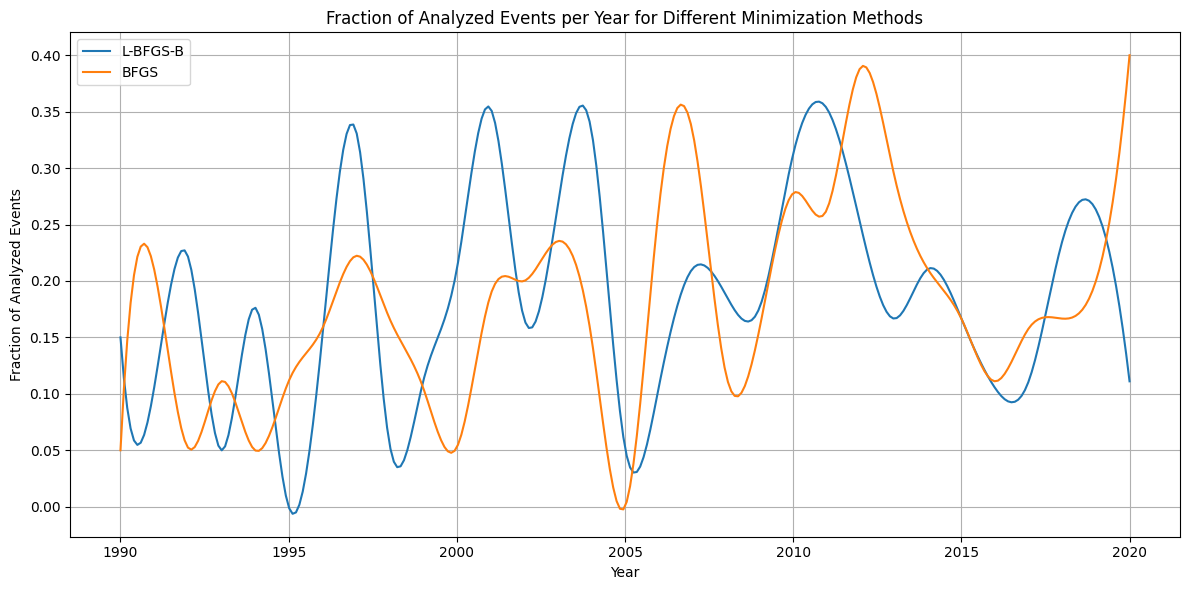

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
import os

def plot_event_fractions(map_year_df_methods, analysis_results_methods, year_range_methods, method_names):
    """Plot the fraction of analyzed events over total events per year with smooth lines for different methods."""
    plt.figure(figsize=(12, 6))
    
    for method_name in method_names:
        map_year_df = map_year_df_methods[method_name]
        analysis_results = analysis_results_methods[method_name]
        year_range = year_range_methods[method_name]
        
        total_events_per_year = {}
        results_per_year = {}

        # Calculate total events per year from the original data
        for year, df in map_year_df.items():
            total_events_per_year[year] = df['rid'].nunique()

        # Calculate results per year from the analysis results
        for year in year_range:
            results_per_year[year] = analysis_results[analysis_results['Year'] == year].shape[0]

        # Prepare data for smooth plotting
        years = np.array(year_range)
        fractions = np.array([results_per_year.get(year, 0) / total_events_per_year.get(year, 1) for year in year_range])

        # Create a smoother line using cubic spline interpolation
        x_new = np.linspace(years.min(), years.max(), 300)
        spline = make_interp_spline(years, fractions, k=3)
        fractions_smooth = spline(x_new)

        # Plot the data
        plt.plot(x_new, fractions_smooth, label=method_name)
    
    plt.xlabel('Year')
    plt.ylabel('Fraction of Analyzed Events')
    plt.title('Fraction of Analyzed Events per Year for Different Minimization Methods')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    output_file = './data/results/fraction_analyzed_events_methods.png'
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    plt.savefig(output_file)
    plt.show()

# Dummy definitions for demonstration purposes
# These should be replaced with the actual data loading steps
def load_dummy_data(method):
    years = range(1990, 2021)
    data = {
        year: pd.DataFrame({'rid': np.random.randint(1, 100, 20)}) for year in years
    }
    results = pd.DataFrame({
        'Year': np.random.choice(years, 100),
        'RaceID': np.random.randint(1, 100, 100),
        'Expected_Rank': np.random.random(100),
        'Normalized_Win_Probability': np.random.random(100)
    })
    return data, results, years

# Load the data for each method
map_year_df_LBFGSB, analysis_results_LBFGSB, year_range_LBFGSB = load_dummy_data("L-BFGS-B")
map_year_df_BFGS, analysis_results_BFGS, year_range_BFGS = load_dummy_data("BFGS")

# Store the data in dictionaries
map_year_df_methods = {
    "L-BFGS-B": map_year_df_LBFGSB,
    "BFGS": map_year_df_BFGS
}
analysis_results_methods = {
    "L-BFGS-B": analysis_results_LBFGSB,
    "BFGS": analysis_results_BFGS
}
year_range_methods = {
    "L-BFGS-B": year_range_LBFGSB,
    "BFGS": year_range_BFGS
}

# Plot the event fractions
plot_event_fractions(map_year_df_methods, analysis_results_methods, year_range_methods, method_names)
